In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import csv
import os, subprocess
import cooler
import cooltools.lib.plotting
import cooltools
from multiprocessing import Pool
import pysam
import bioframe
from scipy.ndimage import gaussian_filter1d
import pandas as pd
import random

In [2]:
# Run the prelim notebook first to generate the balanced cool and the gc cov files

############################
######## PARAMETERS ########
############################

os.chdir('/oak/stanford/groups/tttt/users/achuthan/research/plate-c_granule_plate/') # granule
#os.chdir('/oak/stanford/groups/tttt/users/achuthan/research/plate-c_ipsc/') # ipsc

# HEK
#balanced_cool_files_dir = ['/oak/stanford/groups/tttt/users/achuthan/research/plate-c_HEK/primary_hek/coolfiles/balanced_2/',
#                           '/oak/stanford/groups/tttt/users/achuthan/research/plate-c_HEK/merge_hek/coolfiles/balanced_2/']
                           # Have "/" at the end for the above dir string
# granule
balanced_cool_files_dir = ['/oak/stanford/groups/tttt/users/achuthan/research/plate-c_granule_plate/merge_240419a/coolfiles/balanced_2/']
                           # Have "/" at the end for the above dir string
# iPSC
#balanced_cool_files_dir = ['/oak/stanford/groups/tttt/users/achuthan/research/plate-c_ipsc/merged_ARVA2_deep_240928a/coolfiles/balanced_2/']
                           # Have "/" at the end for the above dir string

ref_genome_ID = 'mm10'
resolution = 1000000
resolution_str = '1Mb'

ref_genome = '/oak/stanford/groups/tttt/users/achuthan/tools/cooltools/ref_genomes/'+ref_genome_ID+'.fa'
gc_cov = pd.read_csv('/oak/stanford/groups/tttt/users/achuthan/tools/cooltools/ref_genomes/'+ref_genome_ID+'_gc_cov_'+resolution_str+'.tsv', sep='\t')

# Saddle parameters
Q_LO = 0.02
Q_HI = 0.98
N_GROUPS = 48

In [3]:
balanced_cool_files_all = []
for j in balanced_cool_files_dir:
    bal_files_in_j = [j+i for i in os.listdir(j) if i.endswith('.cool')]
    for bal_file in bal_files_in_j:
        balanced_cool_files_all.append(bal_file)
balanced_cool_files_all = [i for i in balanced_cool_files_all if resolution_str in i]

In [4]:
# Check to see if the files in consideration are the ones needed before proceeding further 
#balanced_cool_files_all

In [5]:
balanced_cool_files = balanced_cool_files_all # Use all of the files
# In this case, all files are considered. If a subset is required for analyses, choose those files accordingly

In [6]:
# This cell is important -- assigns the last element of the cool files list as the last file in the list (to use for ref in saddle calc etc)

#merged_string = 'merged_primary_HEK' # HEK
merged_string = 'merged_granule_240419a' # granule
#merged_string = 'merged_iPSC_240928a' # iPSC

merged_cool = [i for i in balanced_cool_files_all if merged_string in i][0]

for i in balanced_cool_files_all:
    if merged_string in i:
        balanced_cool_files_all.remove(i)
balanced_cool_files.append(merged_cool)
#len(balanced_cool_files)

In [7]:
# Load data
def create_cooler_instance(file):
    #print(f"Creating cooler for {file}")
    return cooler.Cooler(file)
with Pool() as pool:
    clr = pool.map(create_cooler_instance, balanced_cool_files)
    
bins = [clr[i].bins()[:] for i in range(len(clr))]

# Visually inspect bins, gc_cov before proceeding further
#bins[0]
#display(gc_cov)

In [8]:
view_df = [pd.DataFrame({'chrom': clr[i].chromnames,
                        'start': 0,
                        'end': clr[i].chromsizes.values,
                        'name': clr[i].chromnames}
                       ) for i in range(len(clr))]
# View one df
#display(view_df[0])

## Compartments

In [ ]:
####### For granule cells

import logging
logging.basicConfig(filename='error_log.txt', level=logging.ERROR)

def calculate_eigs_cis(args):
    idx, clr_instance, gc_cov, view_df_instance = args
    try:
        print(f"Processing clr index {idx}\n")
        
        # Call the cooltools.eigs_cis function
        cis_eig_result = cooltools.eigs_cis(
            clr=clr_instance,
            phasing_track=gc_cov,
            view_df=view_df_instance,
            n_eigs=3
        )
        return cis_eig_result
    except ValueError as e:
        # Log the error and continue
        logging.error(f"Error processing clr index {idx}: {str(e)}")
        return None

# Set up arguments for parallel processing
args = [(i, clr[i], gc_cov, view_df[i]) for i in range(len(clr))]

# Use multiprocessing to parallelize the loop
with Pool() as pool:
    cis_eigs = pool.map(calculate_eigs_cis, args)

# Filter out any None values
#cis_eigs = [eig for eig in cis_eigs if eig is not None]
total_len = len(clr)
cis_eigs_new = []
clr_new = []
view_df_new = []
balanced_cool_files_new = []
for i in range(total_len):
    if cis_eigs[i] is not None:
        cis_eigs_new.append(cis_eigs[i])
        clr_new.append(clr[i])
        view_df_new.append(view_df[i])
        balanced_cool_files_new.append(balanced_cool_files[i])

cis_eigs = cis_eigs_new
clr = clr_new
view_df = view_df_new
balanced_cool_files = balanced_cool_files_new

# cis_eigs[0] returns eigenvalues, here we focus on eigenvectors
eigenvector_track = [ cis_eigs[i][1][['chrom','start','end','E1']] for i in range(len(clr))]

In [ ]:
####### For HEK cells, ipsc

def calculate_eigs_cis(args):
    idx, clr_instance, gc_cov, view_df_instance = args
    print(f"Processing clr index {idx}\n")
    
    # Call the cooltools.eigs_cis function
    cis_eig_result = cooltools.eigs_cis(
        clr=clr_instance,
        phasing_track=gc_cov,
        view_df=view_df_instance,
        n_eigs=3
    )
    return cis_eig_result

# Set up arguments for parallel processing
args = [(i, clr[i], gc_cov, view_df[i]) for i in range(len(clr))]

# Use multiprocessing to parallelize the loop
cis_eigs = []  # to store the results
with Pool() as pool:
    cis_eigs = pool.map(calculate_eigs_cis, args)

# cis_eigs[0] returns eigenvalues, here we focus on eigenvectors
eigenvector_track = [ cis_eigs[i][1][['chrom','start','end','E1']] for i in range(len(clr))]

## Saddle plot and strength  

In [10]:
# Define the function that will be parallelized
def calculate_expected_cis(args):
    idx, clr_instance, view_df_instance = args
    print(f"Processing clr index {idx}\n")
    
    # Call the cooltools function
    cvd_result = cooltools.expected_cis(
        clr=clr_instance,
        view_df=view_df_instance,
    )
    return cvd_result

args = [(i, clr[i], view_df[i]) for i in range(len(clr))]
cvd = []
with Pool() as pool:
    cvd = pool.map(calculate_expected_cis, args)

Processing clr index 8
Processing clr index 0
Processing clr index 22
Processing clr index 26
Processing clr index 24
Processing clr index 14
Processing clr index 6

Processing clr index 12



Processing clr index 10
Processing clr index 38
Processing clr index 20
Processing clr index 28
Processing clr index 4
Processing clr index 16

Processing clr index 32


Processing clr index 18


Processing clr index 36


Processing clr index 42


Processing clr index 44
Processing clr index 40





Processing clr index 50



Processing clr index 46

Processing clr index 30

Processing clr index 34




Processing clr index 58





Processing clr index 54
Processing clr index 56
Processing clr index 52
Processing clr index 2
Processing clr index 48


Processing clr index 60



Processing clr index 74
Processing clr index 78



Processing clr index 70

Processing clr index 64


Processing clr index 76


Processing clr index 72

Processing clr index 90
Processing clr index 94

Processing clr index 86
Processing clr index 82
Processing clr index 84



Processing clr index 62
Processing clr index 92
Processing clr index 68
Processing clr index 100
Processing clr index 80
Processing clr index 104
Processing clr index 88
Processing clr index 96


Processing clr index 102





Processing clr index 66


Processing clr index 98
Processing clr index 108



Processing clr index 112



Processing clr index 114






Processing clr index 106


Processing clr index 126
Processing clr index 128
Processing clr index 154
Processing clr index 122
Processing clr index 130

Processing clr index 120
Processing clr index 146
Processing clr index 118
Processing clr index 142
Processing clr index 166
Processing clr index 116
Processing clr index 132
Processing clr index 180
Processing clr index 176
Processing clr index 170
Processing clr index 168
Processing clr index 172
Processing clr index 158
Processing clr index 136
Processing clr index 110
Processing clr index 124
Processing clr index 138

Processing clr index 174
Processing clr index 160
Processing clr index 178
Processing clr index 156
Processing clr index 162
Processing clr index 152

Processing clr index 150
Processing clr index 134
Processing clr index 200

Processing clr index 182


Processing clr index 148
Processing clr index 196
Processing clr index 144
Processing clr index 184
Processing clr index 140
Processing clr index 186



Processing clr index 204



Processing clr index 164
Processing clr index 206





Processing clr index 194
Processing clr index 192
Processing clr index 198


Processing clr index 202


Processing clr index 190

Processing clr index 208




Processing clr index 210








Processing clr index 212
Processing clr index 188


Processing clr index 214








Processing clr index 216


Processing clr index 222


Processing clr index 218



Processing clr index 220


Processing clr index 224



Processing clr index 226






Processing clr index 234


Processing clr index 242
Processing clr index 254
Processing clr index 244


Processing clr index 238
Processing clr index 248


Processing clr index 252
Processing clr index 250
Processing clr index 240
Processing clr index 230
Processing clr index 236


Processing clr index 232


Processing clr index 246


Processing clr index 228


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 183



Processing clr index 21



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 223



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 129



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 63



Processing clr index 256
Processing clr index 215
Processing clr index 99
Processing clr index 111






Processing clr index 109



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 23



Processing clr index 17


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 51

Processing clr index 61


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 37



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 117



Processing clr index 258



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 103



Processing clr index 131


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 89



Processing clr index 3



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 179

Processing clr index 127


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 207


Processing clr index 105


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))




Processing clr index 260



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 149

Processing clr index 253



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 225



Processing clr index 79



Processing clr index 235



Processing clr index 262
Processing clr index 165
Processing clr index 143





Processing clr index 264
Processing clr index 266


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 201




/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 53



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 29



Processing clr index 11


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 221



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 219

Processing clr index 175
Processing clr index 7



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 203



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 169


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 245



Processing clr index 73


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 229



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 97



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 85


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 268
Processing clr index 270



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 35



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 272


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 69
Processing clr index 145



Processing clr index 274
Processing clr index 276


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 55



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 115



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 205
Processing clr index 191




/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 157



Processing clr index 177


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 25


Processing clr index 199


Processing clr index 47



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 278



Processing clr index 280
Processing clr index 163
Processing clr index 282


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 31


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 75



Processing clr index 251



Processing clr index 227


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 284


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 141


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 288
Processing clr index 286


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 87

Processing clr index 81


Processing clr index 233




/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 39
Processing clr index 95
Processing clr index 153





/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 257



Processing clr index 189



Processing clr index 265


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 290



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 167

Processing clr index 173


Processing clr index 15

Processing clr index 197



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 71
Processing clr index 77




/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 121
Processing clr index 125
Processing clr index 13




/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 27


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 292



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 294


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 259



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 296



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 159


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 261


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 59

Processing clr index 217


Processing clr index 237


Processing clr index 298


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 300


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 181


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 273
Processing clr index 119



Processing clr index 161



Processing clr index 302

Processing clr index 93
Processing clr index 45
Processing clr index 304
Processing clr index 171


Processing clr index 306


Processing clr index 113

Processing clr index 308



Processing clr index 310


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 33



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 312
Processing clr index 123
Processing clr index 314




/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 133



Processing clr index 147



Processing clr index 316
Processing clr index 211


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 41
Processing clr index 101




Processing clr index 318
Processing clr index 107




Processing clr index 57

Processing clr index 155
Processing clr index 320




Processing clr index 322



Processing clr index 324



Processing clr index 326


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 255



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 267


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 328
Processing clr index 67


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 263



Processing clr index 213
Processing clr index 137

Processing clr index 241




/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 332
Processing clr index 330


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 334



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 336

Processing clr index 275


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 49


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 83

Processing clr index 65
Processing clr index 231



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 338



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 279


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 269



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 342
Processing clr index 340


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))




Processing clr index 344


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 9



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 187



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 193



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 293



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 151


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 139
Processing clr index 243




/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 135



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 271



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 277



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 239



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 285


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 287



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 289



Processing clr index 301



Processing clr index 249



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 247



Processing clr index 283
Processing clr index 291



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 309



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 281



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 295



Processing clr index 299



Processing clr index 305



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 185



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 325



Processing clr index 341



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 307



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 321
Processing clr index 329
Processing clr index 311




/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 195

Processing clr index 345


Processing clr index 331



Processing clr index 297


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 43




Processing clr index 313



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 209


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 327



Processing clr index 315



Processing clr index 346
Processing clr index 350
Processing clr index 348

Processing clr index 354
Processing clr index 352

Processing clr index 343



Processing clr index 358
Processing clr index 356


Processing clr index 360

Processing clr index 364


Processing clr index 362


Processing clr index 366


Processing clr index 368




Processing clr index 372
Processing clr index 370


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 374


Processing clr index 376


Processing clr index 378
Processing clr index 382


Processing clr index 380

Processing clr index 303


Processing clr index 384






Processing clr index 386
Processing clr index 388


Processing clr index 390
Processing clr index 392
Processing clr index 396

Processing clr index 400



Processing clr index 394
Processing clr index 398
Processing clr index 402
Processing clr index 404



Processing clr index 406




Processing clr index 410

Processing clr index 412



Processing clr index 414
Processing clr index 416



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 426
Processing clr index 424
Processing clr index 418
Processing clr index 422
Processing clr index 420



Processing clr index 408


Processing clr index 428






Processing clr index 430


Processing clr index 432

Processing clr index 436
Processing clr index 434
Processing clr index 438

Processing clr index 442




Processing clr index 440



Processing clr index 444
Processing clr index 448


Processing clr index 446


Processing clr index 452


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))




Processing clr index 450


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 454

Processing clr index 456



Processing clr index 5


Processing clr index 458



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 460


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 462
Processing clr index 91

Processing clr index 470


Processing clr index 464



Processing clr index 466
Processing clr index 468


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 472


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 474
Processing clr index 476


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 478


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 335


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 19



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 317


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 480


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 482


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 484


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 486



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 488


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 333


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 339


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 490
Processing clr index 492




/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 494


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 496



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 498



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 500



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 502

Processing clr index 504


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 506



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 337


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 508


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 510


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 512


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 514



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 516



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 518


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 522
Processing clr index 520

Processing clr index 319




Processing clr index 526


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 401
Processing clr index 524



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 528



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 530


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 323



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 532



Processing clr index 534
Processing clr index 536




/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 538



Processing clr index 540



Processing clr index 542



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 351



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 544


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 433



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 353


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 546



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 548



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 443


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 550



Processing clr index 357


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 552

Processing clr index 1


Processing clr index 439



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 405



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 451
Processing clr index 455



Processing clr index 554


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 556
Processing clr index 347

Processing clr index 431




Processing clr index 558


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 409



Processing clr index 560

Processing clr index 383


Processing clr index 461



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 425



Processing clr index 371



Processing clr index 369



Processing clr index 562

Processing clr index 375



Processing clr index 403



Processing clr index 417
Processing clr index 564




Processing clr index 421


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 485


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 501

Processing clr index 395


Processing clr index 447
Processing clr index 566
Processing clr index 415





Processing clr index 361


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 389

Processing clr index 487


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 499


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 363

Processing clr index 453

Processing clr index 481



Processing clr index 373
Processing clr index 457



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 463


Processing clr index 475



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 491

Processing clr index 568


Processing clr index 385


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 572
Processing clr index 570




/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 449


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 574



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 427



Processing clr index 441
Processing clr index 503
Processing clr index 539



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 469

Processing clr index 429
Processing clr index 479


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 576




Processing clr index 349


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 473
Processing clr index 367


Processing clr index 533

Processing clr index 423


Processing clr index 525


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 505

Processing clr index 477


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 387


Processing clr index 578



Processing clr index 531


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 483



Processing clr index 580



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 582



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 435
Processing clr index 523
Processing clr index 399



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))




Processing clr index 407


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 509



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 379
Processing clr index 584




Processing clr index 586



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 537
Processing clr index 511


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 547



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 527



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 377


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 391


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 493


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 588


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 519



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 393


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 471


Processing clr index 489


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 411
Processing clr index 590



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 381


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 517


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 355


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 467
Processing clr index 445




/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 535
Processing clr index 592



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 541



Processing clr index 495

Processing clr index 594


Processing clr index 596


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 437




/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 598



Processing clr index 497
Processing clr index 600


Processing clr index 602


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 359

Processing clr index 545



Processing clr index 551


Processing clr index 397



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 604



Processing clr index 365
Processing clr index 515


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 529



Processing clr index 606


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 608


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 557



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 419



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 610



Processing clr index 559


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 612


Processing clr index 614


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 563



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 521



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 616



Processing clr index 618


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 459


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 620

Processing clr index 622



Processing clr index 553


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 624


Processing clr index 626

Processing clr index 543



Processing clr index 628



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 630


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 555



Processing clr index 632


Processing clr index 549


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 634


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 636


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 413

Processing clr index 465
Processing clr index 638




Processing clr index 640


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 642


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 644

Processing clr index 646


Processing clr index 648



Processing clr index 650

Processing clr index 579


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 652



Processing clr index 654



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 656

Processing clr index 658



Processing clr index 660



Processing clr index 573



Processing clr index 662


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 664


Processing clr index 666
Processing clr index 668


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 670


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 507

Processing clr index 571


Processing clr index 672
Processing clr index 561

Processing clr index 674




/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 585



Processing clr index 676

Processing clr index 678


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 575


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 682


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 680
Processing clr index 684





/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 686


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 569



Processing clr index 587
Processing clr index 688

Processing clr index 690

Processing clr index 692


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 694



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 513



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 696



Processing clr index 567



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 698


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 599
Processing clr index 565
Processing clr index 700

Processing clr index 702




/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 704



Processing clr index 706



Processing clr index 583


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 589


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 708


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 710



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 712



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 603



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 714



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 716
Processing clr index 597



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 718



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 720
Processing clr index 722



Processing clr index 724



Processing clr index 726



Processing clr index 730
Processing clr index 728




/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 593


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 732



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 591


Processing clr index 601


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 734
Processing clr index 581


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 736


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 738



Processing clr index 742
Processing clr index 740


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 744
Processing clr index 609



Processing clr index 748



Processing clr index 746


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 750


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 752
Processing clr index 617



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 754

Processing clr index 635


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 619
Processing clr index 756


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 631



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 758
Processing clr index 625


Processing clr index 760


Processing clr index 643
Processing clr index 641

Processing clr index 621




Processing clr index 623
Processing clr index 629




/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 762



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 595


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 764



Processing clr index 766
Processing clr index 768




/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 605



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 770



Processing clr index 772


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 577


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 774




/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 615



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 776



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 679



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 778
Processing clr index 683


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 780


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 782

Processing clr index 611


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 627


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 784


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 786



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 788



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 607



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 790



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 657
Processing clr index 661




/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 637



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 663


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 792


Processing clr index 649

Processing clr index 667



Processing clr index 794
Processing clr index 796


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 798



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 800


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 613
Processing clr index 802




Processing clr index 673


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 804

Processing clr index 645


Processing clr index 651




Processing clr index 655


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 806



Processing clr index 713
Processing clr index 687




/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 665

Processing clr index 699



Processing clr index 808


Processing clr index 633



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 810
Processing clr index 693




Processing clr index 695

Processing clr index 647



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 723



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 707
Processing clr index 675




Processing clr index 677


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 697
Processing clr index 705



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 717
Processing clr index 711




/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 814
Processing clr index 812


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 681


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 816


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 671



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 701

Processing clr index 639



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 818


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 659




Processing clr index 743


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 653



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 820


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 822


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 824
Processing clr index 731
Processing clr index 709





/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 691


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 826



Processing clr index 828


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 745




Processing clr index 830



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 832
Processing clr index 727




/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 834


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 779
Processing clr index 836


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 757
Processing clr index 733



Processing clr index 755



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 838



Processing clr index 842
Processing clr index 840




Processing clr index 844


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 846
Processing clr index 689
Processing clr index 729





/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 763



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 719


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 848
Processing clr index 739



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 761



Processing clr index 850


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 685



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 751
Processing clr index 852


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 765



Processing clr index 703



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 669



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 854

Processing clr index 856



Processing clr index 858
Processing clr index 860


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 775


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 862

Processing clr index 864


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 866


Processing clr index 797


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 721



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 789



Processing clr index 801

Processing clr index 868


Processing clr index 741

Processing clr index 767


Processing clr index 870



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 872



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 787



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 749



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 874

Processing clr index 803


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 771
Processing clr index 785



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 876



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 747
Processing clr index 878
Processing clr index 725


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 880



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 882


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 795



Processing clr index 783


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 793



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 884


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 807



Processing clr index 769



Processing clr index 886



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 781
Processing clr index 715
Processing clr index 811


Processing clr index 805
Processing clr index 888




Processing clr index 799



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 845



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 890



Processing clr index 892


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 894



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 737



Processing clr index 896
Processing clr index 898




Processing clr index 900



Processing clr index 791



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 904
Processing clr index 902



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 906


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 908



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 735


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 910
Processing clr index 912
Processing clr index 914



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 821


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 916



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 809


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 918



Processing clr index 920


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 922


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 924



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 773



Processing clr index 835



Processing clr index 847



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 863


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 827



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 833

Processing clr index 837


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 819



Processing clr index 857



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 841



Processing clr index 825
Processing clr index 777




Processing clr index 815


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 871


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 849



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 753
Processing clr index 831

Processing clr index 829



Processing clr index 813
Processing clr index 817


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 759




/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 855



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 907



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 851



Processing clr index 875



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 881



Processing clr index 839



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 883


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 893



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 891



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 919



Processing clr index 903



Processing clr index 895



Processing clr index 897



Processing clr index 873


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 885



Processing clr index 911



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 865
Processing clr index 921
Processing clr index 925


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 853



Processing clr index 913

Processing clr index 869


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 915


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 859


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 909



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 823



Processing clr index 901



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 861



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 879
Processing clr index 867


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))



Processing clr index 917


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


Processing clr index 843




Processing clr index 877


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

Processing clr index 889



Processing clr index 923
Processing clr index 887



Processing clr index 905



Processing clr index 899



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/expected.py:351: FutureWa

In [11]:
import multiprocessing
multiprocessing.cpu_count()

128

In [12]:
from multiprocessing import Pool

def calculate_saddle(args):
    file_idx, clr_instance, cvd_data, eigenvector_track, view_df, N_GROUPS, Q_LO, Q_HI = args
    print(f"Starting saddle calculation for file {file_idx}")
    is_data, ic_data = cooltools.saddle(
        clr_instance,
        cvd_data,
        eigenvector_track,
        'cis',
        n_bins=N_GROUPS,
        qrange=(Q_LO, Q_HI),
        view_df=view_df
    )
    print(f"Completed saddle calculation for file {file_idx}")
    return is_data, ic_data

# eigenvector_track[-1] ensures the eigenvector for the merged file is being used in the calculations
args = [(i, clr[i], cvd[i], eigenvector_track[-1], view_df[i], N_GROUPS, Q_LO, Q_HI) for i in range(len(clr))]
with Pool() as pool:
    results = pool.map(calculate_saddle, args)
interaction_sum, interaction_count = zip(*results)
interaction_sum = list(interaction_sum)
interaction_count = list(interaction_count)

Starting saddle calculation for file 0

Starting saddle calculation for file 4Starting saddle calculation for file 2
Starting saddle calculation for file 6
Starting saddle calculation for file 8
Starting saddle calculation for file 10
Starting saddle calculation for file 12
Starting saddle calculation for file 14


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Starting saddle calculation for file 16

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 18


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 20
Starting saddle calculation for file 22

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 24

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 26
Starting saddle calculation for file 28

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 30Starting saddle calculation for file 32



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 34
Starting saddle calculation for file 36

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 38

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 40


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 42

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 44
Starting saddle calculation for file 48
Starting saddle calculation for file 46Starting saddle calculation for file 52
Starting saddle calculation for file 50


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 54

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 56

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Starting saddle calculation for file 58

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 60


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Starting saddle calculation for file 62

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Starting saddle calculation for file 64

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 68Starting saddle calculation for file 66



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Starting saddle calculation for file 70

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 72

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Starting saddle calculation for file 74Starting saddle calculation for file 76

Starting saddle calculation for file 78


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Starting saddle calculation for file 80
Starting saddle calculation for file 82

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 84

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 86

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 88

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 90

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 92

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Starting saddle calculation for file 94

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 96

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 98

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 100

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Starting saddle calculation for file 102
Starting saddle calculation for file 104


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 106Starting saddle calculation for file 108


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 110
Starting saddle calculation for file 112



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 114
Starting saddle calculation for file 116

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name

Starting saddle calculation for file 118

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 120


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Starting saddle calculation for file 122


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 124

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 126


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 128
Starting saddle calculation for file 130


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 132

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Starting saddle calculation for file 134

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Starting saddle calculation for file 136

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of obse

Starting saddle calculation for file 138

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Starting saddle calculation for file 140
Starting saddle calculation for file 142


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 144


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 146


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 148
Starting saddle calculation for file 150


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Starting saddle calculation for file 152

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Starting saddle calculation for file 154Starting saddle calculation for file 156



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 158


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 160

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 162
Starting saddle calculation for file 164

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 166


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Starting saddle calculation for file 168


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 170


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Starting saddle calculation for file 172

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 174Starting saddle calculation for file 176



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 178

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 180
Starting saddle calculation for file 182

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 184

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Starting saddle calculation for file 186


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 188Starting saddle calculation for file 190



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 192


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 194

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 196

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 198

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 200

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Starting saddle calculation for file 202

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 204



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 206

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 208

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Starting saddle calculation for file 210


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 212


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of obse

Starting saddle calculation for file 216Starting saddle calculation for file 214

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 220Starting saddle calculation for file 218Starting saddle calculation for file 222



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 224
Starting saddle calculation for file 228

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 232Starting saddle calculation for file 230


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 226Starting saddle calculation for file 236Starting saddle calculation for file 234


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Starting saddle calculation for file 238

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 240

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 242


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Starting saddle calculation for file 244

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 246

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 250

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 252Starting saddle calculation for file 248

Starting saddle calculation for file 254

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 254
Starting saddle calculation for file 255


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 246


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 247


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 210
Starting saddle calculation for file 211


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 252
Starting saddle calculation for file 253


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 88
Starting saddle calculation for file 89
Completed saddle calculation for file 48
Starting saddle calculation for file 49
Completed saddle calculation for file 224
Starting saddle calculation for file 225Completed saddle calculation for file 230

Starting saddle calculation for file 231


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 32
Starting saddle calculation for file 33


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 122
Starting saddle calculation for file 123Completed saddle calculation for file 18

Starting saddle calculation for file 19
Completed saddle calculation for file 236
Starting saddle calculation for file 237


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 182
Starting saddle calculation for file 183


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 138
Starting saddle calculation for file 139

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 90

Starting saddle calculation for file 91


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 240

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 241


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 4Completed saddle calculation for file 232
Starting saddle calculation for file 5

Starting saddle calculation for file 233


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 8
Starting saddle calculation for file 9


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 220
Starting saddle calculation for file 221


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 12
Starting saddle calculation for file 13

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Completed saddle calculation for file 214
Starting saddle calculation for file 215


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 242


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 188Starting saddle calculation for file 243

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):




Starting saddle calculation for file 189

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 114

Starting saddle calculation for file 115


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 192
Starting saddle calculation for file 193

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Completed saddle calculation for file 16

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 42Starting saddle calculation for file 17

Starting saddle calculation for file 43


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 84Completed saddle calculation for file 46

Starting saddle calculation for file 85Starting saddle calculation for file 47



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 154
Starting saddle calculation for file 155


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 124
Starting saddle calculation for file 125


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 100

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 101


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 206


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 207


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 116
Starting saddle calculation for file 117


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 106

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 107


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 68
Starting saddle calculation for file 69
Completed saddle calculation for file 20
Completed saddle calculation for file 176

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 152Starting saddle calculation for file 21
Starting saddle calculation for file 153Completed saddle calculation for file 110





/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 111
Starting saddle calculation for file 177

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Completed saddle calculation for file 238

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 239
Completed saddle calculation for file 198

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 


Starting saddle calculation for file 199Completed saddle calculation for file 58

Starting saddle calculation for file 59

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 22


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 23

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 148

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 149


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 40

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 212
Starting saddle calculation for file 213

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 66



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 41

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 67


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 128Completed saddle calculation for file 10


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 129
Completed saddle calculation for file 60
Completed saddle calculation for file 162Starting saddle calculation for file 11

Completed saddle calculation for file 24
Starting saddle calculation for file 61
Starting saddle calculation for file 163



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 25
Completed saddle calculation for file 50Completed saddle calculation for file 62

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 2

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 180




/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 63Starting saddle calculation for file 51


Starting saddle calculation for file 3Starting saddle calculation for file 181

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Completed saddle calculation for file 70

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 71

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 190

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 191

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 228

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 82


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 229

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 83


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Completed saddle calculation for file 132

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 170Completed saddle calculation for file 202

Starting saddle calculation for file 133Starting saddle calculation for file 171




/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 203

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 118
Starting saddle calculation for file 119

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 250

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 251
Completed saddle calculation for file 92

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 172


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 93

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 173


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 74


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 75Completed saddle calculation for file 216



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 217

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 52

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 44Completed saddle calculation for file 6
Starting saddle calculation for file 53

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 45
Starting saddle calculation for file 7
Completed saddle calculation for file 244


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 234Starting saddle calculation for file 245

Starting saddle calculation for file 235

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 196

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 197

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 78

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 36Completed saddle calculation for file 200

Completed saddle calculation for file 204
Completed saddle calculation for file 64Starting saddle calculation for file 79

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 201

Starting saddle calculation for file 37


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 65Completed saddle calculation for file 146


Starting saddle calculation for file 205

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Completed saddle calculation for file 178Starting saddle calculation for file 147

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):




Completed saddle calculation for file 86Starting saddle calculation for file 179

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):




Starting saddle calculation for file 87

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 222



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 72Starting saddle calculation for file 223

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Completed saddle calculation for file 174Completed saddle calculation for file 0
Starting saddle calculation for file 73


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 175Completed saddle calculation for file 112Starting saddle calculation for file 1

Starting saddle calculation for file 113

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 248Completed saddle calculation for file 108


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 80

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 249

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 144Starting saddle calculation for file 81



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):




Starting saddle calculation for file 109Starting saddle calculation for file 145

Completed saddle calculation for file 218

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Completed saddle calculation for file 14Starting saddle calculation for file 219

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):




Starting saddle calculation for file 15


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 142

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 143


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 156Completed saddle calculation for file 184


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 185

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 160Starting saddle calculation for file 157

Starting saddle calculation for file 161

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 26


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 166
Starting saddle calculation for file 167Starting saddle calculation for file 27

Completed saddle calculation for file 134
Starting saddle calculation for file 135


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encou

Completed saddle calculation for file 158

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 159

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Completed saddle calculation for file 28
Completed saddle calculation for file 104

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 29Completed saddle calculation for file 168

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):





Starting saddle calculation for file 105Completed saddle calculation for file 94Starting saddle calculation for file 169

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):





Starting saddle calculation for file 95

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 194Completed saddle calculation for file 102
Starting saddle calculation for file 195



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 103
Completed saddle calculation for file 76

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Starting saddle calculation for file 77

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 186

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 187


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 130
Starting saddle calculation for file 131


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 126

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 127Completed saddle calculation for file 96

Starting saddle calculation for file 97
Completed saddle calculation for file 120

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 121Completed saddle calculation for file 208Completed saddle calculation for file 98


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat




Starting saddle calculation for file 209Starting saddle calculation for file 99



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 54
Starting saddle calculation for file 55


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 136
Starting saddle calculation for file 137
Completed saddle calculation for file 226

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 227


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 150
Starting saddle calculation for file 151


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 56


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 57
Completed saddle calculation for file 140
Starting saddle calculation for file 141


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed

Completed saddle calculation for file 30
Starting saddle calculation for file 31Completed saddle calculation for file 164
Starting saddle calculation for file 165



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 34

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 35


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of obse

Completed saddle calculation for file 38
Starting saddle calculation for file 39


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed

Completed saddle calculation for file 255
Starting saddle calculation for file 256


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 253
Starting saddle calculation for file 258


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 247
Starting saddle calculation for file 260


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 221
Starting saddle calculation for file 262


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 241
Starting saddle calculation for file 264
Completed saddle calculation for file 237
Starting saddle calculation for file 266

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 211
Completed saddle calculation for file 233Starting saddle calculation for file 268

Starting saddle calculation for file 270


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 225
Starting saddle calculation for file 272


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 123
Starting saddle calculation for file 274


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 249
Starting saddle calculation for file 276


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 193
Starting saddle calculation for file 278


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 245
Starting saddle calculation for file 280


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 215
Starting saddle calculation for file 282


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 256
Starting saddle calculation for file 257


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 89
Starting saddle calculation for file 284


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 239
Completed saddle calculation for file 85


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 139Starting saddle calculation for file 288Starting saddle calculation for file 286


Starting saddle calculation for file 290


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 91
Starting saddle calculation for file 292


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 243
Starting saddle calculation for file 294

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 9


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 296
Completed saddle calculation for file 149
Starting saddle calculation for file 298

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 33Completed saddle calculation for file 231



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 300

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 133Starting saddle calculation for file 302


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat




Starting saddle calculation for file 304


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 113Completed saddle calculation for file 181

Starting saddle calculation for file 306Starting saddle calculation for file 308



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 223


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 310


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 119
Starting saddle calculation for file 312


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 19

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 314


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 251


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 316

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 179


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 318


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 189
Starting saddle calculation for file 320


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 213
Starting saddle calculation for file 322
Completed saddle calculation for file 21


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 49
Starting saddle calculation for file 324Starting saddle calculation for file 326

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):




Completed saddle calculation for file 217


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 169Starting saddle calculation for file 328

Starting saddle calculation for file 330
Completed saddle calculation for file 171

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 332


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 43


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 334


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 203
Starting saddle calculation for file 336

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Completed saddle calculation for file 127
Starting saddle calculation for file 338


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 177


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 340

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 235Completed saddle calculation for file 167Completed saddle calculation for file 173


Completed saddle calculation for file 25Starting saddle calculation for file 342Completed saddle calculation for file 137Starting saddle calculation for file 346
Starting saddle calculation for file 344




/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Completed saddle calculation for file 107Starting saddle calculation for file 348

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 350



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 352


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 205Completed saddle calculation for file 47

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 354Starting saddle calculation for file 356



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 125


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 358
Completed saddle calculation for file 5

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 360


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 51

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 


Starting saddle calculation for file 362


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 183

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 364

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 163

Starting saddle calculation for file 366

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 101Completed saddle calculation for file 207
Starting saddle calculation for file 368

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat




Starting saddle calculation for file 370

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 191


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Completed saddle calculation for file 71Starting saddle calculation for file 372



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 374

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 227

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Completed saddle calculation for file 15Starting saddle calculation for file 376

Completed saddle calculation for file 59Starting saddle calculation for file 378

Starting saddle calculation for file 380

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 129
Starting saddle calculation for file 382

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 61
Starting saddle calculation for file 384

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of obse

Completed saddle calculation for file 229
Completed saddle calculation for file 3Completed saddle calculation for file 155

Starting saddle calculation for file 386

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 388


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 97Starting saddle calculation for file 390


Starting saddle calculation for file 392

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 187


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 394


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 195
Starting saddle calculation for file 396Completed saddle calculation for file 199
Starting saddle calculation for file 398


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Completed saddle calculation for file 201Completed saddle calculation for file 13

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 400Starting saddle calculation for file 402



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 117Completed saddle calculation for file 53Completed saddle calculation for file 75

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 404

Starting saddle calculation for file 406

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Starting saddle calculation for file 408


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Completed saddle calculation for file 147Completed saddle calculation for file 153

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 410Completed saddle calculation for file 157Starting saddle calculation for file 412
Completed saddle calculation for file 175


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 414

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 416


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 121

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 418


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of obse

Completed saddle calculation for file 197
Starting saddle calculation for file 420
Completed saddle calculation for file 161
Starting saddle calculation for file 422


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 69

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 424Completed saddle calculation for file 219

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 426


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 159


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 428


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 109

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 115

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat




Starting saddle calculation for file 430Starting saddle calculation for file 432



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 37

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e


Starting saddle calculation for file 434


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 83


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 436

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 63

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 438

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Completed saddle calculation for file 17
Completed saddle calculation for file 111

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 440
Completed saddle calculation for file 23
Completed saddle calculation for file 11Starting saddle calculation for file 442


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 444

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 446Completed saddle calculation for file 143



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 448


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 87

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 450


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 81
Starting saddle calculation for file 452

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 67

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 454


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 145

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Completed saddle calculation for file 99Starting saddle calculation for file 456

Completed saddle calculation for file 141Starting saddle calculation for file 458
Completed saddle calculation for file 79

Starting saddle calculation for file 460Starting saddle calculation for file 462



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 73


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 464


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 95

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 466


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 29


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 65
Starting saddle calculation for file 468

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 470

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed

Completed saddle calculation for file 209
Starting saddle calculation for file 472
Completed saddle calculation for file 135

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 1Starting saddle calculation for file 474

Starting saddle calculation for file 476


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 41

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 478

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of obse

Completed saddle calculation for file 93
Starting saddle calculation for file 480


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 185
Completed saddle calculation for file 151Starting saddle calculation for file 482

Starting saddle calculation for file 484


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 131

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Completed saddle calculation for file 39Starting saddle calculation for file 486Completed saddle calculation for file 45


Starting saddle calculation for file 488
Starting saddle calculation for file 490Completed saddle calculation for file 55

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 31

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 492
Starting saddle calculation for file 494


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 105

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Completed saddle calculation for file 165


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 496

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 498



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 77
Starting saddle calculation for file 500
Completed saddle calculation for file 7
Starting saddle calculation for file 502


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 103
Starting saddle calculation for file 504


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 57

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 506


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name

Completed saddle calculation for file 27
Starting saddle calculation for file 508


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encou

Completed saddle calculation for file 257
Starting saddle calculation for file 510


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 262
Starting saddle calculation for file 263


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 258
Completed saddle calculation for file 35Starting saddle calculation for file 259

Starting saddle calculation for file 512


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 266
Starting saddle calculation for file 267


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 272
Starting saddle calculation for file 273
Completed saddle calculation for file 260
Starting saddle calculation for file 261

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 316
Starting saddle calculation for file 317


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 278
Starting saddle calculation for file 279
Completed saddle calculation for file 276
Starting saddle calculation for file 277


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 268

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 269Completed saddle calculation for file 264

Starting saddle calculation for file 265


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 280


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 281


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 270
Starting saddle calculation for file 271


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 294
Starting saddle calculation for file 295


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 286


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 287


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 274
Starting saddle calculation for file 275


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 328
Starting saddle calculation for file 329


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 338


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 339


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 282
Starting saddle calculation for file 283


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 376
Starting saddle calculation for file 377


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 382
Starting saddle calculation for file 383


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 310
Starting saddle calculation for file 311


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 322


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 323


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 318

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 319
Completed saddle calculation for file 300

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 301


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 306
Starting saddle calculation for file 307
Completed saddle calculation for file 350
Starting saddle calculation for file 351

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 336
Starting saddle calculation for file 337Completed saddle calculation for file 288

Starting saddle calculation for file 289


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 366
Starting saddle calculation for file 367


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 364
Starting saddle calculation for file 365


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 308
Starting saddle calculation for file 309


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 422
Starting saddle calculation for file 423


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 354
Starting saddle calculation for file 355


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 428
Starting saddle calculation for file 429
Completed saddle calculation for file 346
Starting saddle calculation for file 347

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 302
Starting saddle calculation for file 303

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 400
Starting saddle calculation for file 401
Completed saddle calculation for file 298Completed saddle calculation for file 440



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 299Starting saddle calculation for file 441



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 368


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 369

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 372

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 373


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 362
Starting saddle calculation for file 363


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 290
Starting saddle calculation for file 291


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 342


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 343


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 358
Starting saddle calculation for file 359

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 408
Completed saddle calculation for file 390Starting saddle calculation for file 409

Starting saddle calculation for file 391Completed saddle calculation for file 326

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 327

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 460Completed saddle calculation for file 304

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):




Completed saddle calculation for file 340Starting saddle calculation for file 305Starting saddle calculation for file 461Completed saddle calculation for file 472


Starting saddle calculation for file 341

Starting saddle calculation for file 473


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 380

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 381

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Completed saddle calculation for file 448
Starting saddle calculation for file 449

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 412


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 413


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 386


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 387


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encou

Completed saddle calculation for file 498
Starting saddle calculation for file 499Completed saddle calculation for file 284

Starting saddle calculation for file 285

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Completed saddle calculation for file 292Completed saddle calculation for file 420

Starting saddle calculation for file 293

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 421



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 296Completed saddle calculation for file 446

Starting saddle calculation for file 297Starting saddle calculation for file 447



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 494


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 495
Completed saddle calculation for file 312

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 313

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 320
Starting saddle calculation for file 321Completed saddle calculation for file 334

Starting saddle calculation for file 335

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 348
Starting saddle calculation for file 349Completed saddle calculation for file 410

Starting saddle calculation for file 411
Completed saddle calculation for file 402
Starting saddle calculation for file 403


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 510
Starting saddle calculation for file 511


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 426
Starting saddle calculation for file 427

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Completed saddle calculation for file 344


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 345


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 406

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 407


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 414
Starting saddle calculation for file 415


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 398
Starting saddle calculation for file 399

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 394
Starting saddle calculation for file 395
Completed saddle calculation for file 332

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 333


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 436
Starting saddle calculation for file 437
Completed saddle calculation for file 356
Starting saddle calculation for file 357Completed saddle calculation for file 352Completed saddle calculation for file 434

Completed saddle calculation for file 370Starting saddle calculation for file 353


Starting saddle calculation for file 371Starting saddle calculation for file 435


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Completed saddle calculation for file 314Completed saddle calculation for file 388

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):




Starting saddle calculation for file 389

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 315



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 416


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 417
Completed saddle calculation for file 482
Starting saddle calculation for file 483


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 442
Starting saddle calculation for file 443

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Completed saddle calculation for file 404Completed saddle calculation for file 396



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 397Starting saddle calculation for file 405



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 324
Completed saddle calculation for file 424Starting saddle calculation for file 325

Starting saddle calculation for file 425

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 444
Starting saddle calculation for file 445


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 378
Starting saddle calculation for file 379
Completed saddle calculation for file 392

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 393
Completed saddle calculation for file 450

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 451


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 360
Starting saddle calculation for file 361


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 466
Starting saddle calculation for file 467


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 432
Starting saddle calculation for file 433


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 464
Starting saddle calculation for file 465


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 438
Starting saddle calculation for file 439Completed saddle calculation for file 330

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 454


Completed saddle calculation for file 374Starting saddle calculation for file 455

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 331


Starting saddle calculation for file 375


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 263
Starting saddle calculation for file 514

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encou

Completed saddle calculation for file 468
Starting saddle calculation for file 469

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Completed saddle calculation for file 458

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 459


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 277

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 516


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 476
Starting saddle calculation for file 477

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 384


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 385


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 273
Completed saddle calculation for file 492Starting saddle calculation for file 518


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 493


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 462
Completed saddle calculation for file 478Starting saddle calculation for file 463
Starting saddle calculation for file 479



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 418
Starting saddle calculation for file 419
Completed saddle calculation for file 508


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 509


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 470


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 471
Completed saddle calculation for file 486

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 487


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 430

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Completed saddle calculation for file 480
Starting saddle calculation for file 481Starting saddle calculation for file 431



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 506
Starting saddle calculation for file 507
Completed saddle calculation for file 456

Starting saddle calculation for file 457

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 502

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 503


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 271
Starting saddle calculation for file 520


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 295
Starting saddle calculation for file 522

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 261


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 524


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 484
Starting saddle calculation for file 485


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 452

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 453


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 500

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 501


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 490
Starting saddle calculation for file 491
Completed saddle calculation for file 267
Starting saddle calculation for file 526


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 311
Starting saddle calculation for file 528
Completed saddle calculation for file 504
Starting saddle calculation for file 505

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Completed saddle calculation for file 474
Starting saddle calculation for file 475


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 259

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 530
Completed saddle calculation for file 488

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 489


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 281
Starting saddle calculation for file 532
Completed saddle calculation for file 496
Starting saddle calculation for file 497


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 317
Starting saddle calculation for file 534
Completed saddle calculation for file 265
Starting saddle calculation for file 536


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of obse

Completed saddle calculation for file 512
Starting saddle calculation for file 513


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 269
Starting saddle calculation for file 538


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 301
Starting saddle calculation for file 540


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 283
Starting saddle calculation for file 542


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 365
Starting saddle calculation for file 544
Completed saddle calculation for file 279


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 546


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 287
Starting saddle calculation for file 548


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 377
Starting saddle calculation for file 550

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 461
Starting saddle calculation for file 552


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 305
Completed saddle calculation for file 319
Starting saddle calculation for file 554Starting saddle calculation for file 556



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 473


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 558


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 339
Starting saddle calculation for file 560


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 401
Starting saddle calculation for file 562


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 275
Starting saddle calculation for file 564


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 511
Starting saddle calculation for file 566
Completed saddle calculation for file 355

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 568


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 369
Starting saddle calculation for file 570
Completed saddle calculation for file 351
Starting saddle calculation for file 572


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encou

Completed saddle calculation for file 383


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 574


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 289
Starting saddle calculation for file 576
Completed saddle calculation for file 409Completed saddle calculation for file 329

Starting saddle calculation for file 578Starting saddle calculation for file 580



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 345
Starting saddle calculation for file 582


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 387


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 584


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 337


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 586Completed saddle calculation for file 421

Starting saddle calculation for file 588

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 307Completed saddle calculation for file 373

Completed saddle calculation for file 417Starting saddle calculation for file 590Completed saddle calculation for file 449
Starting saddle calculation for file 592
Starting saddle calculation for file 596
Starting saddle calculation for file 594




/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 429
Starting saddle calculation for file 598


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 367
Starting saddle calculation for file 600

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 499
Starting saddle calculation for file 602


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 299


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 604


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 447

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Completed saddle calculation for file 333Starting saddle calculation for file 606

Starting saddle calculation for file 608
Completed saddle calculation for file 303
Starting saddle calculation for file 610


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 427
Starting saddle calculation for file 612


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 347
Starting saddle calculation for file 614


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of obse

Completed saddle calculation for file 391
Starting saddle calculation for file 616

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 343
Starting saddle calculation for file 618


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encou

Completed saddle calculation for file 522
Starting saddle calculation for file 523
Completed saddle calculation for file 423
Starting saddle calculation for file 620


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 321


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 622


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 293
Starting saddle calculation for file 624


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 441
Starting saddle calculation for file 626
Completed saddle calculation for file 415
Starting saddle calculation for file 628


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 323
Completed saddle calculation for file 516Starting saddle calculation for file 630

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):




Starting saddle calculation for file 517

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 495
Completed saddle calculation for file 403
Starting saddle calculation for file 632Starting saddle calculation for file 634



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 359
Starting saddle calculation for file 636
Completed saddle calculation for file 327


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 638Completed saddle calculation for file 520



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 521

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Completed saddle calculation for file 483
Completed saddle calculation for file 313
Starting saddle calculation for file 640


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 642

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 309

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 644

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Completed saddle calculation for file 514
Starting saddle calculation for file 515


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 353


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 646


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of obse

Completed saddle calculation for file 534Completed saddle calculation for file 405

Starting saddle calculation for file 648
Starting saddle calculation for file 535


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 407

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Completed saddle calculation for file 371
Starting saddle calculation for file 650Starting saddle calculation for file 652Completed saddle calculation for file 291




/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 654
Completed saddle calculation for file 357

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 656


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 285Completed saddle calculation for file 395



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 658Starting saddle calculation for file 660



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 437
Completed saddle calculation for file 524Starting saddle calculation for file 662

Starting saddle calculation for file 525Completed saddle calculation for file 363

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 664

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 397
Starting saddle calculation for file 666

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 399


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 668


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 425


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 670Completed saddle calculation for file 530


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 531

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of obse

Completed saddle calculation for file 297

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 672

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 335
Starting saddle calculation for file 674Completed saddle calculation for file 536

Starting saddle calculation for file 537


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 393
Completed saddle calculation for file 341Starting saddle calculation for file 676


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 678



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 411

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 680


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of obse

Completed saddle calculation for file 455
Starting saddle calculation for file 682


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of obse

Completed saddle calculation for file 349
Starting saddle calculation for file 684
Completed saddle calculation for file 381


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 686


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 435

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 688
Completed saddle calculation for file 413

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 690


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 485

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 692


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 518
Starting saddle calculation for file 519Completed saddle calculation for file 469

Starting saddle calculation for file 694


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 459
Starting saddle calculation for file 696


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 526
Starting saddle calculation for file 527
Completed saddle calculation for file 325
Starting saddle calculation for file 698


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 467


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 700Completed saddle calculation for file 443

Completed saddle calculation for file 315

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 702

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 704



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 491

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 706

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Completed saddle calculation for file 542Completed saddle calculation for file 471Completed saddle calculation for file 361

Starting saddle calculation for file 708Starting saddle calculation for file 543


Starting saddle calculation for file 710


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 477
Starting saddle calculation for file 712


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 509
Starting saddle calculation for file 714


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 501


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 716

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 487


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 718


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 389
Starting saddle calculation for file 720

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Completed saddle calculation for file 493
Starting saddle calculation for file 722


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 445

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 724

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 479
Completed saddle calculation for file 465
Starting saddle calculation for file 726
Starting saddle calculation for file 728


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 451


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 730

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 375

Starting saddle calculation for file 732


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 550

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 551


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 379

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 734


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 528

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 439Starting saddle calculation for file 529
Completed saddle calculation for file 481

Starting saddle calculation for file 736
Starting saddle calculation for file 738


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 457
Starting saddle calculation for file 740
Completed saddle calculation for file 431
Starting saddle calculation for file 742
Completed saddle calculation for file 331


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 744


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 419

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 746

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 463

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 748


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 540
Starting saddle calculation for file 541
Completed saddle calculation for file 532


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 533


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 453
Starting saddle calculation for file 750

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 433
Starting saddle calculation for file 752


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 385

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Completed saddle calculation for file 566
Starting saddle calculation for file 754Starting saddle calculation for file 567



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 538
Starting saddle calculation for file 539
Completed saddle calculation for file 503

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 756

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Completed saddle calculation for file 598


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 599


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of obse

Completed saddle calculation for file 497
Starting saddle calculation for file 758Completed saddle calculation for file 505

Starting saddle calculation for file 760

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 507
Starting saddle calculation for file 762


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 588
Starting saddle calculation for file 589


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of obse

Completed saddle calculation for file 552
Starting saddle calculation for file 553


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 564
Starting saddle calculation for file 565

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 544
Starting saddle calculation for file 545


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 560
Starting saddle calculation for file 561


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 489


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 764


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 475
Completed saddle calculation for file 548Starting saddle calculation for file 766

Starting saddle calculation for file 549


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 546
Starting saddle calculation for file 547


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 584
Starting saddle calculation for file 585


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of obse

Completed saddle calculation for file 582
Starting saddle calculation for file 583


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 568


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 569
Completed saddle calculation for file 517


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 768
Completed saddle calculation for file 558

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 559


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 612
Starting saddle calculation for file 613

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 646
Starting saddle calculation for file 647


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 562
Starting saddle calculation for file 563


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 513
Starting saddle calculation for file 770


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 578
Starting saddle calculation for file 579


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 554Completed saddle calculation for file 592

Starting saddle calculation for file 555
Starting saddle calculation for file 593


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 590
Starting saddle calculation for file 591
Completed saddle calculation for file 556
Starting saddle calculation for file 557


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 515Completed saddle calculation for file 570

Starting saddle calculation for file 772Starting saddle calculation for file 571



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 596
Starting saddle calculation for file 597


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 525
Starting saddle calculation for file 774


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 658
Starting saddle calculation for file 659


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encou

Completed saddle calculation for file 600
Starting saddle calculation for file 601


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 576Completed saddle calculation for file 640Completed saddle calculation for file 634


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat




Starting saddle calculation for file 577
Starting saddle calculation for file 635Starting saddle calculation for file 641



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 620

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 621

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 602
Starting saddle calculation for file 603Completed saddle calculation for file 614

Starting saddle calculation for file 615

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 586
Starting saddle calculation for file 587


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 574

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 535


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 575

Starting saddle calculation for file 776


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 521
Starting saddle calculation for file 778
Completed saddle calculation for file 622
Starting saddle calculation for file 623


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 537
Starting saddle calculation for file 780

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 572


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 573


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 608

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 609


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 628
Starting saddle calculation for file 629
Completed saddle calculation for file 618

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 523

Starting saddle calculation for file 619Starting saddle calculation for file 782Completed saddle calculation for file 594



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 595



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 656

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Completed saddle calculation for file 678
Starting saddle calculation for file 679Starting saddle calculation for file 657


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 580
Completed saddle calculation for file 666

Starting saddle calculation for file 581Starting saddle calculation for file 667



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 636Completed saddle calculation for file 610

Starting saddle calculation for file 611Starting saddle calculation for file 637



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 654

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 655


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 680
Starting saddle calculation for file 681Completed saddle calculation for file 630


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 631


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 531
Completed saddle calculation for file 638
Starting saddle calculation for file 784

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 639



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 632
Starting saddle calculation for file 633


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 616
Starting saddle calculation for file 617


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 604
Starting saddle calculation for file 605


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 519

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Completed saddle calculation for file 672Starting saddle calculation for file 786
Starting saddle calculation for file 673



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 676
Starting saddle calculation for file 677


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 668
Starting saddle calculation for file 669

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of obse

Completed saddle calculation for file 567


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 788


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 648
Starting saddle calculation for file 649Completed saddle calculation for file 696
Completed saddle calculation for file 606
Starting saddle calculation for file 607


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 664
Starting saddle calculation for file 697



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 665


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 674
Starting saddle calculation for file 675


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 626

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 627
Completed saddle calculation for file 650

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 651
Completed saddle calculation for file 702
Starting saddle calculation for file 703


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of obse

Completed saddle calculation for file 694


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 695


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 698

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 699

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 724
Starting saddle calculation for file 725


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 527
Starting saddle calculation for file 790
Completed saddle calculation for file 642


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 643

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Completed saddle calculation for file 543

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 792


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 710

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 711
Completed saddle calculation for file 644

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 645

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name

Completed saddle calculation for file 660
Starting saddle calculation for file 661


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 704

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 705


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encou

Completed saddle calculation for file 708
Starting saddle calculation for file 709


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 688
Starting saddle calculation for file 689


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 684
Starting saddle calculation for file 685Completed saddle calculation for file 652


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 653
Completed saddle calculation for file 624
Starting saddle calculation for file 625


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 718
Completed saddle calculation for file 670Starting saddle calculation for file 719


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 671



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 692


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 693


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 662


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 599Starting saddle calculation for file 663

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 794

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 722

Starting saddle calculation for file 723Completed saddle calculation for file 529

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Completed saddle calculation for file 682
Completed saddle calculation for file 756
Starting saddle calculation for file 796
Starting saddle calculation for file 683

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 757


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 744

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 745


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 720
Starting saddle calculation for file 721


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 533
Starting saddle calculation for file 798


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 740
Starting saddle calculation for file 741
Completed saddle calculation for file 539
Starting saddle calculation for file 800

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 690
Starting saddle calculation for file 691
Completed saddle calculation for file 728Completed saddle calculation for file 712
Starting saddle calculation for file 713
Starting saddle calculation for file 729
Completed saddle calculation for file 551

Starting saddle calculation for file 802

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 716
Starting saddle calculation for file 717


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 686


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 687

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed

Completed saddle calculation for file 752
Starting saddle calculation for file 753


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 732Completed saddle calculation for file 746

Starting saddle calculation for file 733Starting saddle calculation for file 747

Completed saddle calculation for file 583
Starting saddle calculation for file 804


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 758
Starting saddle calculation for file 759


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 714
Starting saddle calculation for file 715
Completed saddle calculation for file 700

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 701


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 742
Starting saddle calculation for file 743
Completed saddle calculation for file 541
Starting saddle calculation for file 806

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 738Completed saddle calculation for file 760
Starting saddle calculation for file 739


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 761


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 754


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 755

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 748

Starting saddle calculation for file 749


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 706


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 569Starting saddle calculation for file 707


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 808



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 736
Starting saddle calculation for file 737


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 589
Starting saddle calculation for file 810


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 734
Starting saddle calculation for file 735


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 726
Starting saddle calculation for file 727


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 762
Starting saddle calculation for file 763


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 545
Starting saddle calculation for file 812


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 641
Starting saddle calculation for file 814
Completed saddle calculation for file 730
Starting saddle calculation for file 731


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 547


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 816


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 563
Completed saddle calculation for file 750Starting saddle calculation for file 818
Starting saddle calculation for file 751



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 553
Starting saddle calculation for file 820


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 585


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 822


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 565
Starting saddle calculation for file 824


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of obse

Completed saddle calculation for file 776
Starting saddle calculation for file 777


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 772
Starting saddle calculation for file 773


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 579Completed saddle calculation for file 561

Starting saddle calculation for file 826Starting saddle calculation for file 828



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 629
Starting saddle calculation for file 830


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 788
Completed saddle calculation for file 559
Starting saddle calculation for file 789
Starting saddle calculation for file 832
Completed saddle calculation for file 557
Starting saddle calculation for file 834


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 770
Starting saddle calculation for file 771
Completed saddle calculation for file 593
Starting saddle calculation for file 836


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 603
Starting saddle calculation for file 838


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 657
Starting saddle calculation for file 840


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 549
Starting saddle calculation for file 842


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 659
Starting saddle calculation for file 844
Completed saddle calculation for file 591


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 613Starting saddle calculation for file 846

Starting saddle calculation for file 848


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 597
Starting saddle calculation for file 850


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 619


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 852


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 778
Starting saddle calculation for file 779
Completed saddle calculation for file 601
Starting saddle calculation for file 854

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of obse

Completed saddle calculation for file 625
Starting saddle calculation for file 856
Completed saddle calculation for file 768
Starting saddle calculation for file 769


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 780
Starting saddle calculation for file 781


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 571


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 858


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 766
Starting saddle calculation for file 767
Completed saddle calculation for file 573
Starting saddle calculation for file 860
Completed saddle calculation for file 798

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 799
Completed saddle calculation for file 774
Starting saddle calculation for file 775


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 647Completed saddle calculation for file 609



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 862Starting saddle calculation for file 864



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 555
Starting saddle calculation for file 866


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 655

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 868


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 587
Starting saddle calculation for file 870


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 764


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 765


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 689
Starting saddle calculation for file 872
Completed saddle calculation for file 577

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 874


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 792
Starting saddle calculation for file 793


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 635
Starting saddle calculation for file 876


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of obse

Completed saddle calculation for file 649


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 878


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 679
Starting saddle calculation for file 880


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 621
Starting saddle calculation for file 882
Completed saddle calculation for file 667
Starting saddle calculation for file 884


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 581
Starting saddle calculation for file 886


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 786

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 787

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 681
Starting saddle calculation for file 888


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 627
Starting saddle calculation for file 890


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of obse

Completed saddle calculation for file 790
Completed saddle calculation for file 575
Starting saddle calculation for file 892Starting saddle calculation for file 791



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 611

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 894


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 595


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 896Completed saddle calculation for file 615


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 898


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 693
Starting saddle calculation for file 900


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 623
Starting saddle calculation for file 902


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 725
Starting saddle calculation for file 904


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 782
Starting saddle calculation for file 783


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 796
Starting saddle calculation for file 797
Completed saddle calculation for file 757
Starting saddle calculation for file 906


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 751
Starting saddle calculation for file 908
Completed saddle calculation for file 784
Starting saddle calculation for file 785


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 882

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 883

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 705

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 910
Completed saddle calculation for file 643
Starting saddle calculation for file 912


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 631

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 914


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 721
Starting saddle calculation for file 916


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 669
Completed saddle calculation for file 665Starting saddle calculation for file 918

Starting saddle calculation for file 920


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 804


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 805


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 605
Starting saddle calculation for file 922


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 719
Starting saddle calculation for file 924


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 661


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 675


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 677
Completed saddle calculation for file 697
Completed saddle calculation for file 695

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 802
Starting saddle calculation for file 803Completed saddle calculation for file 633



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 651Completed saddle calculation for file 818

Starting saddle calculation for file 819

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 826
Completed saddle calculation for file 745Starting saddle calculation for file 827

Completed saddle calculation for file 808
Starting saddle calculation for file 809

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Completed saddle calculation for file 800

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Completed saddle calculation for file 637
Starting saddle calculation for file 801
Completed saddle calculation for file 673

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 761

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 755Completed saddle calculation for file 806

Starting saddle calculation for file 807


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 723


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 683
Completed saddle calculation for file 703
Completed saddle calculation for file 699


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 617
Completed saddle calculation for file 607
Completed saddle calculation for file 709
Completed saddle calculation for file 639
Completed saddle calculation for file 727
Completed saddle calculation for file 753
Completed saddle calculation for file 711

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 767
Completed saddle calculation for file 794
Starting saddle calculation for file 795


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 914
Starting saddle calculation for file 915


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 824
Starting saddle calculation for file 825

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 713
Completed saddle calculation for file 743
Completed saddle calculation for file 759
Completed saddle calculation for file 793


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 787
Completed saddle calculation for file 685
Completed saddle calculation for file 769
Completed saddle calculation for file 801


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 653
Completed saddle calculation for file 812
Completed saddle calculation for file 747Starting saddle calculation for file 813

Completed saddle calculation for file 852Completed saddle calculation for file 717

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):




Starting saddle calculation for file 853


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 739Completed saddle calculation for file 777

Completed saddle calculation for file 687
Completed saddle calculation for file 645


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 663
Completed saddle calculation for file 671
Completed saddle calculation for file 846
Completed saddle calculation for file 840Starting saddle calculation for file 847

Starting saddle calculation for file 841


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 691
Completed saddle calculation for file 860
Starting saddle calculation for file 861


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 729


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 820Completed saddle calculation for file 810
Starting saddle calculation for file 821

Starting saddle calculation for file 811


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 779


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of obse

Completed saddle calculation for file 775


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 715
Completed saddle calculation for file 735


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 809
Completed saddle calculation for file 832
Starting saddle calculation for file 833
Completed saddle calculation for file 830
Starting saddle calculation for file 831
Completed saddle calculation for file 741

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 858
Starting saddle calculation for file 859


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 781
Completed saddle calculation for file 828
Starting saddle calculation for file 829


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 737


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 731Completed saddle calculation for file 707



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 789

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Completed saddle calculation for file 773
Completed saddle calculation for file 902
Starting saddle calculation for file 903


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 749
Completed saddle calculation for file 733
Completed saddle calculation for file 884

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 827

Completed saddle calculation for file 701Completed saddle calculation for file 822Starting saddle calculation for file 885
Starting saddle calculation for file 823


Completed saddle calculation for file 868

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 869
Completed saddle calculation for file 862
Starting saddle calculation for file 863


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 870
Starting saddle calculation for file 871

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 842


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 843

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of obse

Completed saddle calculation for file 866

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 867
Completed saddle calculation for file 763
Completed saddle calculation for file 900
Starting saddle calculation for file 901


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 799


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 850

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 851


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 814
Starting saddle calculation for file 815


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 856
Starting saddle calculation for file 857
Completed saddle calculation for file 783

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 848
Completed saddle calculation for file 816
Starting saddle calculation for file 849Starting saddle calculation for file 817

Completed saddle calculation for file 834
Starting saddle calculation for file 835


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 854

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 855


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 797
Completed saddle calculation for file 836
Starting saddle calculation for file 837


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 892
Starting saddle calculation for file 893


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 890
Starting saddle calculation for file 891


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 771


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 864
Starting saddle calculation for file 865


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 844

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 838

Starting saddle calculation for file 839Starting saddle calculation for file 845



/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 819Completed saddle calculation for file 807Completed saddle calculation for file 874

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Starting saddle calculation for file 875


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 918
Starting saddle calculation for file 919


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 791


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 886
Starting saddle calculation for file 887


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 876

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 765

Starting saddle calculation for file 877
Completed saddle calculation for file 915

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 904
Starting saddle calculation for file 905


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 880

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 881
Completed saddle calculation for file 896Completed saddle calculation for file 785


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 897


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 872
Starting saddle calculation for file 873
Completed saddle calculation for file 878


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Starting saddle calculation for file 879


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 922

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat



Starting saddle calculation for file 923


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 883


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 894
Starting saddle calculation for file 895
Completed saddle calculation for file 888
Starting saddle calculation for file 889


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of 

Completed saddle calculation for file 916
Starting saddle calculation for file 917

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 908
Starting saddle calculation for file 909


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 906
Starting saddle calculation for file 907

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Completed saddle calculation for file 803


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 843Completed saddle calculation for file 898

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat




Starting saddle calculation for file 899


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 853

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 805


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 910
Starting saddle calculation for file 911


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


Completed saddle calculation for file 825
Completed saddle calculation for file 811
Completed saddle calculation for file 912

/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):



Starting saddle calculation for file 913


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 924
Starting saddle calculation for file 925


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for 

Completed saddle calculation for file 823Completed saddle calculation for file 795

Completed saddle calculation for file 885


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 833
Completed saddle calculation for file 859
Completed saddle calculation for file 869
Completed saddle calculation for file 847
Completed saddle calculation for file 813
Completed saddle calculation for file 901
Completed saddle calculation for file 920
Starting saddle calculation for file 921


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value e

Completed saddle calculation for file 817
Completed saddle calculation for file 831


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 841


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat
/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 861
Completed saddle calculation for file 815
Completed saddle calculation for file 821


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 829
Completed saddle calculation for file 849
Completed saddle calculation for file 835


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 871
Completed saddle calculation for file 855
Completed saddle calculation for file 837
Completed saddle calculation for file 851
Completed saddle calculation for file 903
Completed saddle calculation for file 845
Completed saddle calculation for file 881
Completed saddle calculation for file 857


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 839
Completed saddle calculation for file 905
Completed saddle calculation for file 923
Completed saddle calculation for file 891


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 919
Completed saddle calculation for file 893
Completed saddle calculation for file 889
Completed saddle calculation for file 865
Completed saddle calculation for file 907
Completed saddle calculation for file 867
Completed saddle calculation for file 863
Completed saddle calculation for file 911
Completed saddle calculation for file 897
Completed saddle calculation for file 879Completed saddle calculation for file 875

Completed saddle calculation for file 899
Completed saddle calculation for file 887
Completed saddle calculation for file 877
Completed saddle calculation for file 873
Completed saddle calculation for file 895


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


Completed saddle calculation for file 909
Completed saddle calculation for file 921
Completed saddle calculation for file 925
Completed saddle calculation for file 917
Completed saddle calculation for file 913


/oak/stanford/groups/tttt/users/achuthan/tools/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/tmp/ipykernel_95070/3843342417.py:95: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groupmean = track[track.columns[3]].groupby(digitized_track[digitized_track.columns[3]]).mean()


cbar


Text(0.5, 0.98, 'merged_granule_240419a_balanced_1Mb.cool')

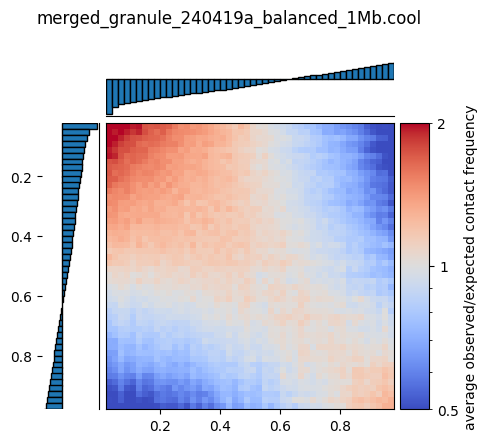

In [15]:
# Plot a specific file
index_plot = -1

saddleplot(eigenvector_track[index_plot],
           interaction_sum[index_plot]/interaction_count[index_plot],
           N_GROUPS,
           qrange=(Q_LO,Q_HI),
           cbar_kws={'label':'average observed/expected contact frequency'}
          );
plt.suptitle(os.path.basename(balanced_cool_files[index_plot]).removesuffix('.mcool'))


Text(0.5, 0.98, 'merged_granule_240419a_balanced_1Mb.cool')

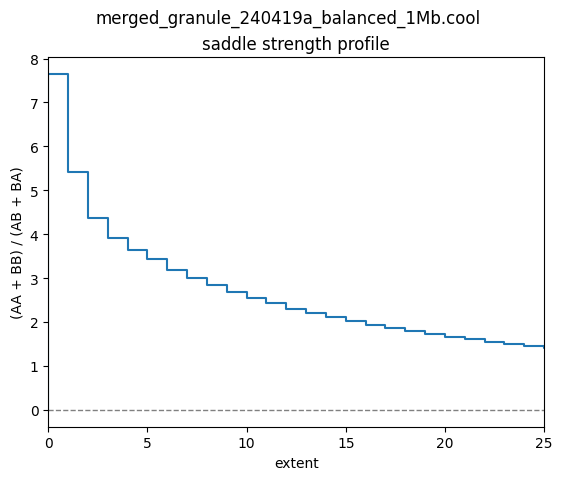

In [16]:
index_plot = -1

from cooltools.api.saddle import saddle_strength
# at extent=0, this reduces to ((S/C)[0,0] + (S/C)[-1,-1]) / (2*(S/C)[-1,0])

x = np.arange(N_GROUPS + 2)

plt.step(x, saddle_strength(interaction_sum[index_plot], interaction_count[index_plot]), where='pre')

plt.xlabel('extent')
plt.ylabel('(AA + BB) / (AB + BA)')
plt.title('saddle strength profile')
plt.axhline(0, c='grey', ls='--', lw=1) # Q: is there a reason this is 0 not 1?
plt.xlim(0, len(x)//2); # Q: is this less intuitive than showing for all x, as it converges to no difference (i.e. 1)?

plt.suptitle(os.path.basename(balanced_cool_files[index_plot]).removesuffix('.mcool'))


## Save data as TSVs

In [ ]:
# hg19 HEK
#metadata_file = "/oak/stanford/groups/tttt/users/achuthan/research/plate-c_HEK/primary_hek/metadata/filelist.txt"
#outputfilestring = "_hek_"
#merge_string = " "
#output_dir = '/oak/stanford/groups/tttt/users/achuthan/research/plate-c_HEK/' # Have "/" at the end

# mm10 granule
metadata_file = "/oak/stanford/groups/tttt/users/achuthan/research/plate-c_granule_plate/merge_240419a/metadata/filelist_2.txt"
outputfilestring = "_granule_"
merge_string = " "
output_dir = '/oak/stanford/groups/tttt/users/achuthan/research/plate-c_granule_plate/' # Have "/" at the end

# hg19 ipsc
#metadata_file = "/oak/stanford/groups/tttt/users/achuthan/research/plate-c_ipsc/merged_ARVA2_deep_240928a/metadata/filelist.txt"
#outputfilestring = "_ipsc_"
#merge_string = "merged_ipsc_240928a"
#output_dir = '/oak/stanford/groups/tttt/users/achuthan/research/plate-c_ipsc/' # Have "/" at the end

metadata_df = pd.read_csv(metadata_file, header=None, usecols=[0, 1], names=["file", "drug"], sep='\t')

In [ ]:
pwd

In [ ]:
os.chdir('/oak/stanford/groups/tttt/users/achuthan/research/plate-c_granule_plate')

In [ ]:
# Make the AABBABBA file - has AA, BB, AB, BA values for the first 26 extents (0-25)
tsv_filename = 'AABBABBAvalues_' + resolution_str + outputfilestring + '50groups_calculation.tsv'
tsv_filename = output_dir + tsv_filename

with open(tsv_filename, mode='w', newline='') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t')
    header = ["file", "drug"] + [f"{interaction}_data{extent}" for extent in range(26) for interaction in ["AA", "BB", "AB", "BA"]]
    writer.writerow(header)

    for i in range(len(balanced_cool_files)):
        file = balanced_cool_files[i]
        drug = "NA"
        
        for index, row in metadata_df.iterrows():
            if not merge_string in file and row['file'] in file:
                drug = row['drug']
                break
            if merge_string in file:
                drug = os.path.basename(file)
                drug = drug.removeprefix(merge_string)
                drug = drug.removesuffix('_balanced_' + resolution_str + '.cool')
                break

        row_data = [os.path.basename(file).removesuffix('_balanced_' + resolution_str + '.cool'), drug]
        for extent in range(26):  # Iterate over 26 extents
            AA, BB, AB, BA = calculate_interactions(i, extent, interaction_sum, interaction_count)
            row_data.extend([AA, BB, AB, BA])
        
        writer.writerow(row_data)

print(f"Data successfully written to {tsv_filename}")


In [ ]:
# AABBABBA file for particular extent only
extent=10
tsv_filename = 'AABBABBAvalues_' + resolution_str + outputfilestring +'extent' +str(extent)+ '_50groups_calculation.tsv'
tsv_filename = output_dir + tsv_filename
AABBABBA_big = pd.read_csv(output_dir+'AABBABBAvalues_' + resolution_str + outputfilestring + '50groups_calculation.tsv', sep='\t')

with open(tsv_filename, mode='w', newline='') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t')  # Use delimiter='\t' for TSV
    header = ["file", "drug", "saddle_strength_extent"+str(extent)]
    writer.writerow(header)

    for i in range(len(AABBABBA_big)):
        file = AABBABBA_big['file'][i]
        drug = AABBABBA_big['drug'][i]
        # The +1 here is due to indexing differences: the "first" set of strength values is all zero by definition
        saddle_strength_val = (AABBABBA_big['AA_data'+str(extent+1)][i] + AABBABBA_big['BB_data'+str(extent+1)][i])/(AABBABBA_big['AB_data'+str(extent+1)][i] + AABBABBA_big['BA_data'+str(extent+1)][i])

        row_data = [file, drug, saddle_strength_val]
        writer.writerow(row_data)

print(f"Data successfully written to {tsv_filename}")

## Functions

In [ ]:
#saddleplot function below from: https://cooltools.readthedocs.io/en/latest/notebooks/compartments_and_saddles.html
#calculate_interactions function also drawn, with modifications, from the tutorial's corresponding function 
#at https://cooltools.readthedocs.io/en/latest/notebooks/compartments_and_saddles.html

In [13]:
import warnings
from cytoolz import merge

def saddleplot(
    track,
    saddledata,
    n_bins,
    vrange=None,
    qrange=(0.0, 1.0),
    cmap="coolwarm",
    scale="log",
    vmin=0.5,
    vmax=2,
    color=None,
    title=None,
    xlabel=None,
    ylabel=None,
    clabel=None,
    fig=None,
    fig_kws=None,
    heatmap_kws=None,
    margin_kws=None,
    cbar_kws=None,
    subplot_spec=None,
):
    """
    Generate a saddle plot.
    Parameters
    ----------
    track : pd.DataFrame
        See cooltools.digitize() for details.
    saddledata : 2D array-like
        Saddle matrix produced by `make_saddle`. It will include 2 flanking
        rows/columns for outlier signal values, thus the shape should be
        `(n+2, n+2)`.
    cmap : str or matplotlib colormap
        Colormap to use for plotting the saddle heatmap
    scale : str
        Color scaling to use for plotting the saddle heatmap: log or linear
    vmin, vmax : float
        Value limits for coloring the saddle heatmap
    color : matplotlib color value
        Face color for margin bar plots
    fig : matplotlib Figure, optional
        Specified figure to plot on. A new figure is created if none is
        provided.
    fig_kws : dict, optional
        Passed on to `plt.Figure()`
    heatmap_kws : dict, optional
        Passed on to `ax.imshow()`
    margin_kws : dict, optional
        Passed on to `ax.bar()` and `ax.barh()`
    cbar_kws : dict, optional
        Passed on to `plt.colorbar()`
    subplot_spec : GridSpec object
        Specify a subregion of a figure to using a GridSpec.
    Returns
    -------
    Dictionary of axes objects.
    """

#     warnings.warn(
#         "Generating a saddleplot will be deprecated in future versions, "
#         + "please see https://github.com/open2c_examples for examples on how to plot saddles.",
#         DeprecationWarning,
#     )

    from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
    from matplotlib.colors import Normalize, LogNorm
    from matplotlib import ticker
    import matplotlib.pyplot as plt

    class MinOneMaxFormatter(ticker.LogFormatter):
        def set_locs(self, locs=None):
            self._sublabels = set([vmin % 10 * 10, vmax % 10, 1])

        def __call__(self, x, pos=None):
            if x not in [vmin, 1, vmax]:
                return ""
            else:
                return "{x:g}".format(x=x)

    track_value_col = track.columns[3]
    track_values = track[track_value_col].values

    digitized_track, binedges = cooltools.digitize(
        track, n_bins, vrange=vrange, qrange=qrange
    )
    x = digitized_track[digitized_track.columns[3]].values.astype(int).copy()
    x = x[(x > -1) & (x < len(binedges) + 1)]

    # Old version
    # hist = np.bincount(x, minlength=len(binedges) + 1)

    groupmean = track[track.columns[3]].groupby(digitized_track[digitized_track.columns[3]]).mean()

    if qrange is not None:
        lo, hi = qrange
        binedges = np.linspace(lo, hi, n_bins + 1)

    # Barplot of mean values and saddledata are flanked by outlier bins
    n = saddledata.shape[0]
    X, Y = np.meshgrid(binedges, binedges)
    C = saddledata
    if (n - n_bins) == 2:
        C = C[1:-1, 1:-1]
        groupmean = groupmean[1:-1]

    # Layout
    if subplot_spec is not None:
        GridSpec = partial(GridSpecFromSubplotSpec, subplot_spec=subplot_spec)
    grid = {}
    gs = GridSpec(
        nrows=3,
        ncols=3,
        width_ratios=[0.2, 1, 0.1],
        height_ratios=[0.2, 1, 0.1],
        wspace=0.05,
        hspace=0.05,
    )

    # Figure
    if fig is None:
        fig_kws_default = dict(figsize=(5, 5))
        fig_kws = merge(fig_kws_default, fig_kws if fig_kws is not None else {})
        fig = plt.figure(**fig_kws)

    # Heatmap
    if scale == "log":
        norm = LogNorm(vmin=vmin, vmax=vmax)
    elif scale == "linear":
        norm = Normalize(vmin=vmin, vmax=vmax)
    else:
        raise ValueError("Only linear and log color scaling is supported")

    grid["ax_heatmap"] = ax = plt.subplot(gs[4])
    heatmap_kws_default = dict(cmap="coolwarm", rasterized=True)
    heatmap_kws = merge(
        heatmap_kws_default, heatmap_kws if heatmap_kws is not None else {}
    )
    img = ax.pcolormesh(X, Y, C, norm=norm, **heatmap_kws)
    plt.gca().yaxis.set_visible(False)

    # Margins
    margin_kws_default = dict(edgecolor="k", facecolor=color, linewidth=1)
    margin_kws = merge(margin_kws_default, margin_kws if margin_kws is not None else {})
    # left margin hist
    grid["ax_margin_y"] = plt.subplot(gs[3], sharey=grid["ax_heatmap"])

    plt.barh(
        binedges, height=1/len(binedges), width=groupmean, align="edge", **margin_kws
    )

    plt.xlim(plt.xlim()[1], plt.xlim()[0])  # fliplr
    plt.ylim(hi, lo)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().xaxis.set_visible(False)
    # top margin hist
    grid["ax_margin_x"] = plt.subplot(gs[1], sharex=grid["ax_heatmap"])

    plt.bar(
        binedges, width=1/len(binedges), height=groupmean, align="edge", **margin_kws
    )

    plt.xlim(lo, hi)
    # plt.ylim(plt.ylim())  # correct
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().xaxis.set_visible(False)
    plt.gca().yaxis.set_visible(False)

#     # Colorbar
    grid["ax_cbar"] = plt.subplot(gs[5])
    cbar_kws_default = dict(fraction=0.8, label=clabel or "")
    cbar_kws = merge(cbar_kws_default, cbar_kws if cbar_kws is not None else {})
    if scale == "linear" and vmin is not None and vmax is not None:
        grid["ax_cbar"] = cb = plt.colorbar(img, **cbar_kws)
        # cb.set_ticks(np.arange(vmin, vmax + 0.001, 0.5))
        # # do linspace between vmin and vmax of 5 segments and trunc to 1 decimal:
        decimal = 10
        nsegments = 5
        cd_ticks = np.trunc(np.linspace(vmin, vmax, nsegments) * decimal) / decimal
        cb.set_ticks(cd_ticks)
    else:
        print('cbar')

        cb = plt.colorbar(img, format=MinOneMaxFormatter(), cax=grid["ax_cbar"], **cbar_kws)
        cb.ax.yaxis.set_minor_formatter(MinOneMaxFormatter())

    # extra settings
    grid["ax_heatmap"].set_xlim(lo, hi)
    grid["ax_heatmap"].set_ylim(hi, lo)
    grid['ax_heatmap'].grid(False)
    if title is not None:
        grid["ax_margin_x"].set_title(title)
    if xlabel is not None:
        grid["ax_heatmap"].set_xlabel(xlabel)
    if ylabel is not None:
        grid["ax_margin_y"].set_ylabel(ylabel)

    return grid

In [14]:
def calculate_interactions(index_plot, extent, interaction_sum, interaction_count):
    S = np.array(interaction_sum)
    C = np.array(interaction_count)

    max_extent = min(interaction_sum[index_plot].shape[0] // 2, interaction_sum[index_plot].shape[1] // 2)
    if extent > max_extent:
        print(f"Warning: extent {extent} is larger than the available matrix size. Using max_extent {max_extent} instead.")
        extent = max_extent
    if extent == 0:
        AA = 0
        BB = 0
        AB = 0
        BA = 0
        return AA, BB, AB, BA
    k = extent

    tot, m, n = S.shape
    # Slicing to calculate AA and BB
    BB_sum = np.nansum(S[index_plot, 0:k, 0:k]) 
    AA_sum = np.nansum(S[index_plot, m - k : m, n - k : n])
    BB_count = np.nansum(C[index_plot, 0:k, 0:k]) 
    AA_count = np.nansum(C[index_plot, m - k : m, n - k : n])
    
    # Slicing to calculate AB and BA
    BA_sum = np.nansum(S[index_plot, 0:k, n - k : n]) 
    AB_sum = np.nansum(S[index_plot, m - k : m, 0:k])
    BA_count = np.nansum(C[index_plot, 0:k, n - k : n]) 
    AB_count = np.nansum(C[index_plot, m - k : m, 0:k])
    
    # Compute AA, BB, AB, and BA interaction values
    AA = AA_sum / AA_count if AA_count != 0 else np.nan
    BB = BB_sum / BB_count if BB_count != 0 else np.nan
    AB = AB_sum / AB_count if AB_count != 0 else np.nan
    BA = BA_sum / BA_count if BA_count != 0 else np.nan

    return AA, BB, AB, BA
